In [3]:
!pip install matplotlib
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

  Using cached matplotlib-3.7.5-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
  Using cached contourpy-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (301 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pillow-10.4.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
     |████████████████████████████████| 4.7 MB 4.7 MB/s eta 0:00:01
  Using cached pyparsing-3.1.4-py3-none-any.whl (104 kB)
  Using cached kiwisolver-1.4.7-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)


### Anonymity Degradation


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial


def plot_anonymity_degradation(original_data, after_day_data, after_week_data, after_month_data, after_year, after_all, tag, subtag=""):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
    def count_of_std(tx: blocksci.Tx, val: int) -> int:
        if tag != "ww1_multiple_txes" or subtag != "ignored":
            return tx.output_count
            
        cnt = 0
        output: blocksci.Output
        for output in tx.outputs:
            if 0.08 * 1e8 <= output.value <= 0.12 * 1e8:
                cnt += 1

        return cnt or 1
            
    df_original = pd.DataFrame(
        # [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        [(transaction.block_time, count / count_of_std(transaction, count)) for transaction, (_, count) in original_data.items()],
        columns=["block_time", "original_anonymity_score"],
    )

    df_after_day = pd.DataFrame(
        [(transaction.block_time, count / count_of_std(transaction, count)) for transaction, (_, count) in after_day_data.items()],
        columns=["block_time", "anonymity_set_after_day"],
    )
    
    df_after_week = pd.DataFrame(
        [(transaction.block_time, count / count_of_std(transaction, count)) for transaction, (_, count) in after_week_data.items()],
        columns=["block_time", "anonymity_set_after_week"],
    )
    df_after_month = pd.DataFrame(
        [(transaction.block_time, count / count_of_std(transaction, count)) for transaction, (_, count) in after_month_data.items()],
        columns=["block_time", "anonymity_set_after_month"],
    )

    df_after_year = pd.DataFrame(
        [(transaction.block_time, count / count_of_std(transaction, count)) for transaction, (_, count) in after_year.items()],
        columns=["block_time", "anonymity_set_after_year"],
    )

    df_after_all = pd.DataFrame(
        [(transaction.block_time, count / count_of_std(transaction, count)) for transaction, (_, count) in after_all.items()],
        columns=["block_time", "anonymity_set_after_all"],
    )
    
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_after_day["block_time"] = pd.to_datetime(df_after_day["block_time"])
    df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])
    df_after_month["block_time"] = pd.to_datetime(df_after_month["block_time"])
    df_after_year["block_time"] = pd.to_datetime(df_after_year["block_time"])
    df_after_all["block_time"] = pd.to_datetime(df_after_all["block_time"])
    
    df_original["week_start"] = df_original["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_day["week_start"] = df_after_day["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_week["week_start"] = df_after_week["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_month["week_start"] = df_after_month["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_year["week_start"] = df_after_year["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_all["week_start"] = df_after_all["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    
    weekly_original = df_original.groupby("week_start")["original_anonymity_score"].mean().reset_index()
    weekly_after_day = df_after_day.groupby("week_start")["anonymity_set_after_day"].mean().reset_index()
    weekly_after_week = df_after_week.groupby("week_start")["anonymity_set_after_week"].mean().reset_index()
    weekly_after_month = df_after_month.groupby("week_start")["anonymity_set_after_month"].mean().reset_index()
    weekly_after_year = df_after_year.groupby("week_start")["anonymity_set_after_year"].mean().reset_index()
    weekly_after_all = df_after_all.groupby("week_start")["anonymity_set_after_all"].mean().reset_index()
    
    weekly_data = pd.merge(weekly_original, weekly_after_week, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_day, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_month, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_year, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_all, on="week_start", how="outer")
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 10))
    plt.plot(
        weekly_data["week_start"],
        weekly_data["original_anonymity_score"],
        label="Initial computed anonymity value",
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_day"],
        label="Computed anonymity value after 1 day",
        linestyle='dotted'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_week"],
        label="Computed anonymity value after 7 days",
        linestyle='dashed',
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_month"],
        label="Computed anonymity value after 31 days",
        linewidth=1,
        linestyle='dashdot'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_year"],
        label="Computed anonymity value after 365 days",
        linestyle='dotted'
    )

    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_all"],
        label="Computed anonymity value with no time limit",
        linestyle='dashed'
    )
    
    plt.xlabel("Week")
    plt.ylabel("Percentage of unconsolidated outputs")
    plt.title(f"Percentage of unconsolidated outputs for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.ylim(ymin=0)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/mnt/blocksci/anonymity_degradation_2_{tag}{'_' + subtag if subtag else ''}.png")
    plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log2, factorial

def compute_and_plot_differences(original_data, after_day_data, after_week_data, after_month_data, after_year_data, tag, subtag=""):
    def make_df(data, col_name):
        df = pd.DataFrame(
            # [(tx.block_time, val / log2(factorial(tx.output_count))) for tx, val in data.items()],
            [(tx.block_time, val / tx.output_count) for tx, (_, val) in data.items()],
            columns=["block_time", col_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("M").apply(lambda r: r.start_time)
        return df

    df_original = make_df(original_data, "original_value")
    df_after_day = make_df(after_day_data, "after_day_value")
    df_after_week = make_df(after_week_data, "after_week_value")
    df_after_month = make_df(after_month_data, "after_month_value")
    df_after_year = make_df(after_year_data, "after_year_value")

    df_original = df_original.groupby("week_start")["original_value"].mean().reset_index()
    df_after_day = df_after_day.groupby("week_start")["after_day_value"].mean().reset_index()
    df_after_week = df_after_week.groupby("week_start")["after_week_value"].mean().reset_index()
    df_after_month = df_after_month.groupby("week_start")["after_month_value"].mean().reset_index()
    df_after_year = df_after_year.groupby("week_start")["after_year_value"].mean().reset_index()

    merged = df_original.merge(df_after_day, on="week_start", how="outer")
    merged = merged.merge(df_after_week, on="week_start", how="outer")
    merged = merged.merge(df_after_month, on="week_start", how="outer")
    merged = merged.merge(df_after_year, on="week_start", how="outer")

    merged["diff_0_1d"] = abs(merged["after_day_value"] - merged["original_value"])
    merged["diff_1d_7d"] = abs(merged["after_week_value"] - merged["after_day_value"])
    merged["diff_7d_31d"] = abs(merged["after_month_value"] - merged["after_week_value"])
    merged["diff_31d_365d"] = abs(merged["after_year_value"] - merged["after_month_value"])

    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16,6))
    plt.plot(merged["week_start"], merged["diff_0_1d"], label="Difference (0–1d)")
    plt.plot(merged["week_start"], merged["diff_1d_7d"], label="Difference (1d–7d)", ls='--')
    plt.plot(merged["week_start"], merged["diff_7d_31d"], label="Difference (7d–31d)", ls=':')
    plt.plot(merged["week_start"], merged["diff_31d_365d"], label="Difference (31d–365d)", ls='-.')

    plt.xlabel("Month")
    plt.ylabel("Difference in anonymity values")
    plt.title(f"Differences (0–1d, 1d–7d, 7d–31d, 31d-365d) for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    #plt.savefig(f"/mnt/blocksci/anonymity_degradation_differences_{tag}{'_' + subtag if subtag else ''}_all.png")
    plt.show()
    
    print("original mean", merged["original_value"].mean())
    print("after day", merged["after_day_value"].mean())
    print("after week", merged["after_week_value"].mean())
    print("after month", merged["after_month_value"].mean())
    print("after year", merged["after_year_value"].mean())


def compute_and_plot_quartiles(after_day_data, after_year_data, tag, subtag=""):
    def make_df(data, col_name):
        df = pd.DataFrame(
            # [(tx.block_time, val / log2(factorial(tx.output_count))) for tx, val in data.items()],
            [(tx.block_time, val / tx.output_count) for tx, (_, val) in data.items()],
            columns=["block_time", col_name],
        )
        df["block_time"] = pd.to_datetime(df["block_time"])
        df["week_start"] = df["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
        return df

    df_after_day = make_df(after_day_data, "after_day_value")
    df_after_year = make_df(after_year_data, "after_year_value")

    merged = pd.merge(df_after_day, df_after_year, on=["block_time","week_start"], how="outer")

    weekly = merged.groupby("week_start").agg({
        "after_day_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
        "after_year_value": ['mean', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
    }).reset_index()

    weekly.columns = [
        "week_start",
        "after_day_mean", "after_day_q1", "after_day_median", "after_day_q3",
        "after_year_mean", "after_year_q1", "after_year_median", "after_year_q3"
    ]
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 10))
    plt.plot(weekly["week_start"], weekly["after_day_mean"], label="After 1 day (mean)", color='blue')
    plt.fill_between(weekly["week_start"], weekly["after_day_q1"], weekly["after_day_q3"], color='blue', alpha=0.2, label="1 day (Q1–Q3)")

    plt.plot(weekly["week_start"], weekly["after_year_mean"], label="After 1 year (mean)", color='red')
    plt.fill_between(weekly["week_start"], weekly["after_year_q1"], weekly["after_year_q3"], color='red', alpha=0.2, label="1 year (Q1–Q3)")
    
    plt.xlabel("Week")
    plt.ylabel("Computed anonymity value")
    plt.title(f"After 1 day and 1 year anonymity values with quartiles for {tag.split('_')[0].upper()}{'_' + subtag if subtag else ''} CoinJoins")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/mnt/blocksci/anonymity_degradation_quartiles_{tag}{'_' + subtag if subtag else ''}_new.png")
    plt.show()

In [6]:
%time ww1_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1")
%time ww1_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1")
%time ww1_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1")
%time ww1_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1")
%time ww1_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1")
%time ww1_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1")

%time ww2_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2")
%time ww2_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2")
%time ww2_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2")
%time ww2_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2")
%time ww2_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2")
%time ww2_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2")


%time sw_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool")
%time sw_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool")
%time sw_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool")
%time sw_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool")
%time sw_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool")
%time sw_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool")

%time sw_original_data_50m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "50m")
%time sw_after_day_data_50m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "50m")
%time sw_after_week_data_50m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "50m")
%time sw_after_month_data_50m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "50m")
%time sw_after_year_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "50m")
%time sw_after_full_data_50m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "50m")

%time sw_original_data_5m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "5m")
%time sw_after_day_data_5m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "5m")
%time sw_after_week_data_5m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "5m")
%time sw_after_month_data_5m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "5m")
%time sw_after_year_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "5m")
%time sw_after_full_data_5m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "5m")


%time sw_original_data_1m = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "1m")
%time sw_after_day_data_1m = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "1m")
%time sw_after_week_data_1m = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "1m")
%time sw_after_month_data_1m = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "1m")
%time sw_after_year_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "1m")
%time sw_after_full_data_1m = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "1m")

%time sw_original_data_100k = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool", "100k")
%time sw_after_day_data_100k = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool", "100k")
%time sw_after_week_data_100k = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool", "100k")
%time sw_after_month_data_100k = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool", "100k")
%time sw_after_year_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool", "100k")
%time sw_after_full_data_100k = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool", "100k")


CPU times: user 2min 26s, sys: 1min 37s, total: 4min 3s
Wall time: 5.44 s
CPU times: user 27min 35s, sys: 12.3 s, total: 27min 47s
Wall time: 12.3 s
CPU times: user 28min 55s, sys: 6.36 s, total: 29min 1s
Wall time: 13.2 s
CPU times: user 29min 13s, sys: 4.9 s, total: 29min 18s
Wall time: 12.9 s
CPU times: user 29min 24s, sys: 3.24 s, total: 29min 27s
Wall time: 14 s
CPU times: user 28min 57s, sys: 3.22 s, total: 29min
Wall time: 13.5 s
CPU times: user 1min 49s, sys: 777 ms, total: 1min 50s
Wall time: 1.26 s
CPU times: user 27min 37s, sys: 7.54 s, total: 27min 45s
Wall time: 12.1 s
CPU times: user 27min 33s, sys: 6.61 s, total: 27min 40s
Wall time: 11.4 s
CPU times: user 28min 31s, sys: 1.63 s, total: 28min 32s
Wall time: 12.5 s
CPU times: user 27min 32s, sys: 4.55 s, total: 27min 37s
Wall time: 11.5 s
CPU times: user 28min 45s, sys: 6.21 s, total: 28min 51s
Wall time: 11.6 s
CPU times: user 2min 3s, sys: 2.8 s, total: 2min 6s
Wall time: 2.99 s
CPU times: user 39min 15s, sys: 10.9 s, t

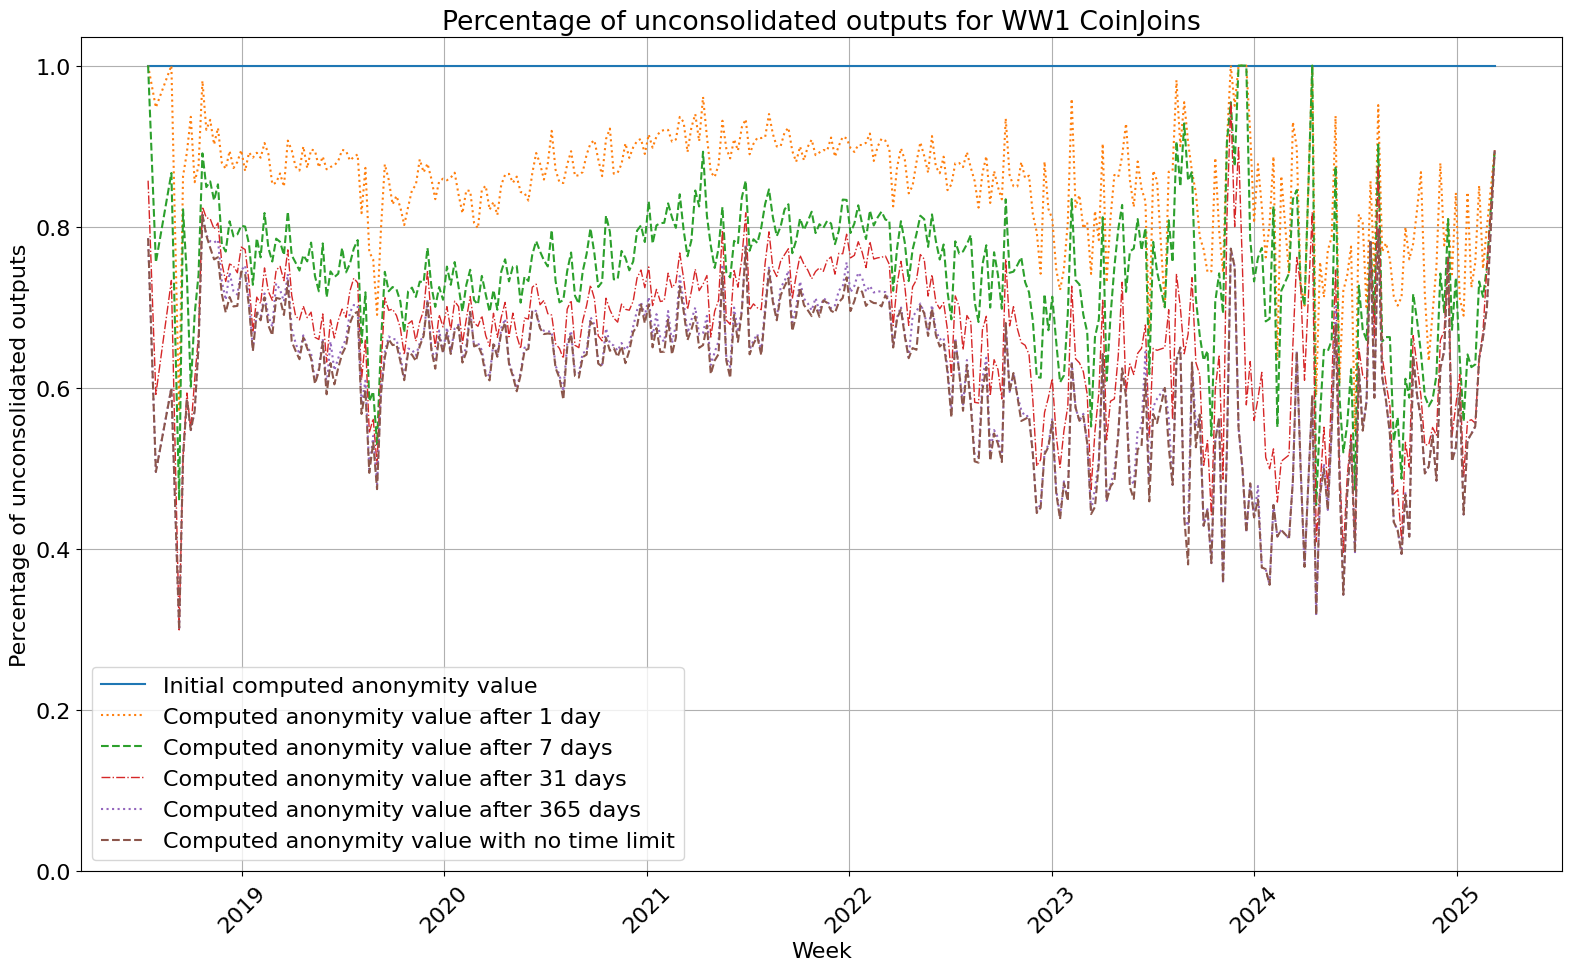

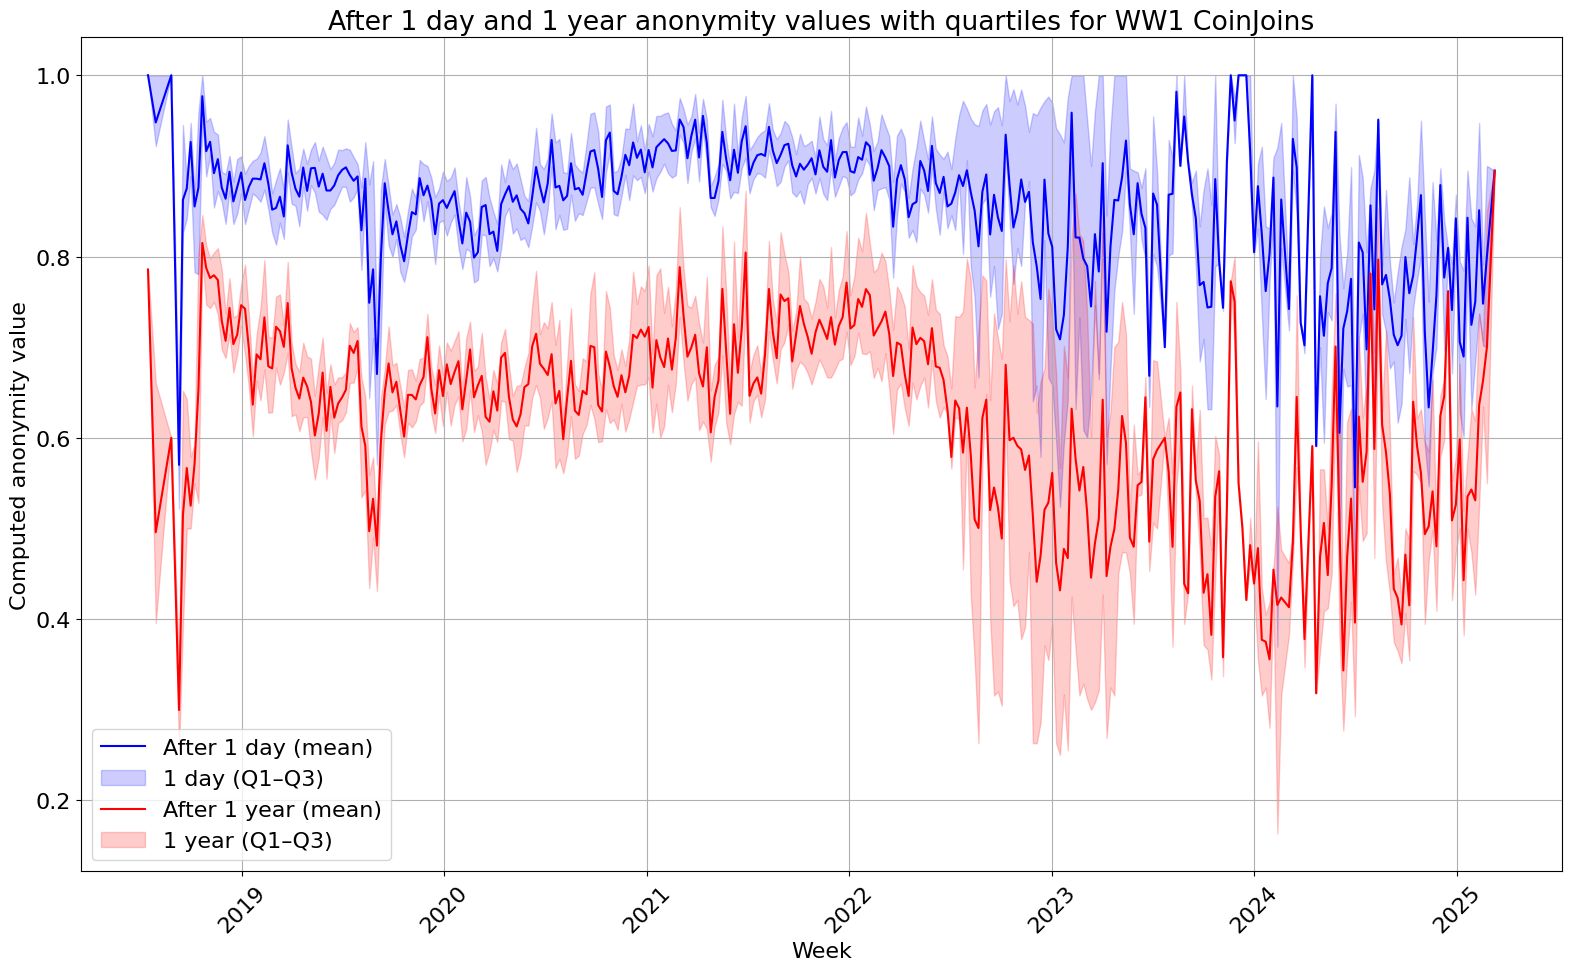

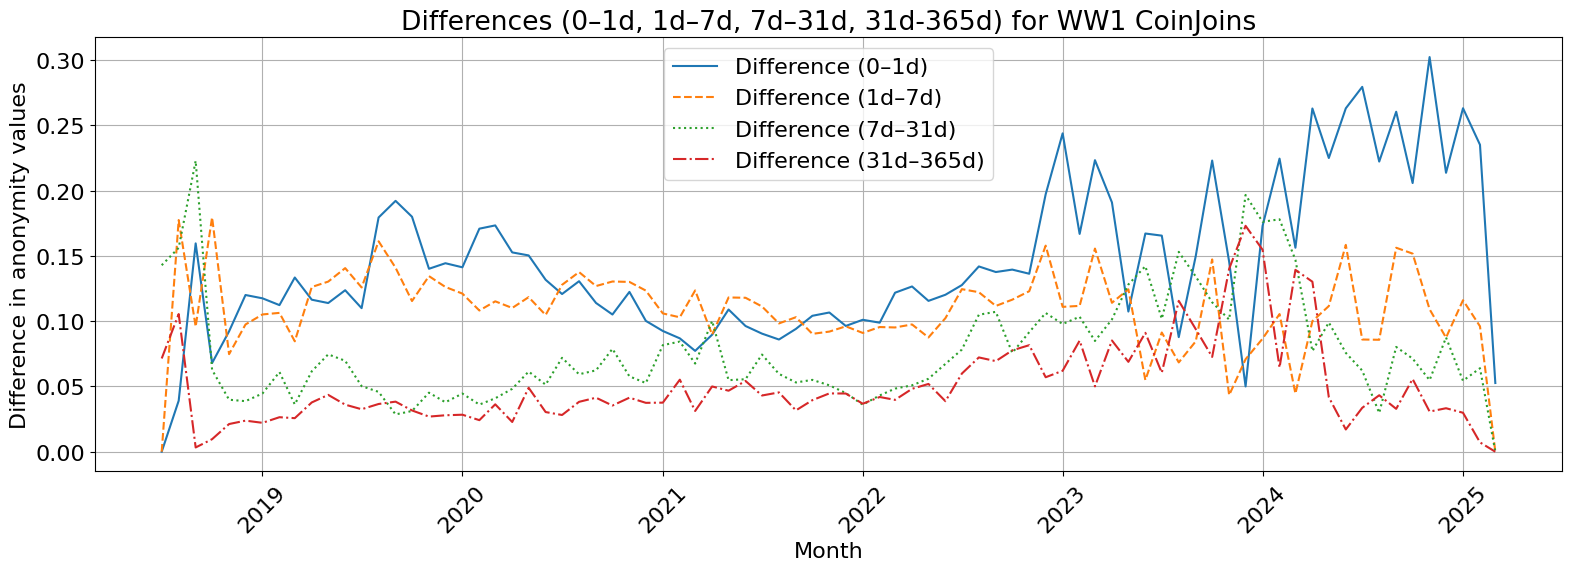

original mean 1.0
after day 0.8554366005360851
after week 0.7465164563560515
after month 0.6690014131212909
after year 0.6178413135651595


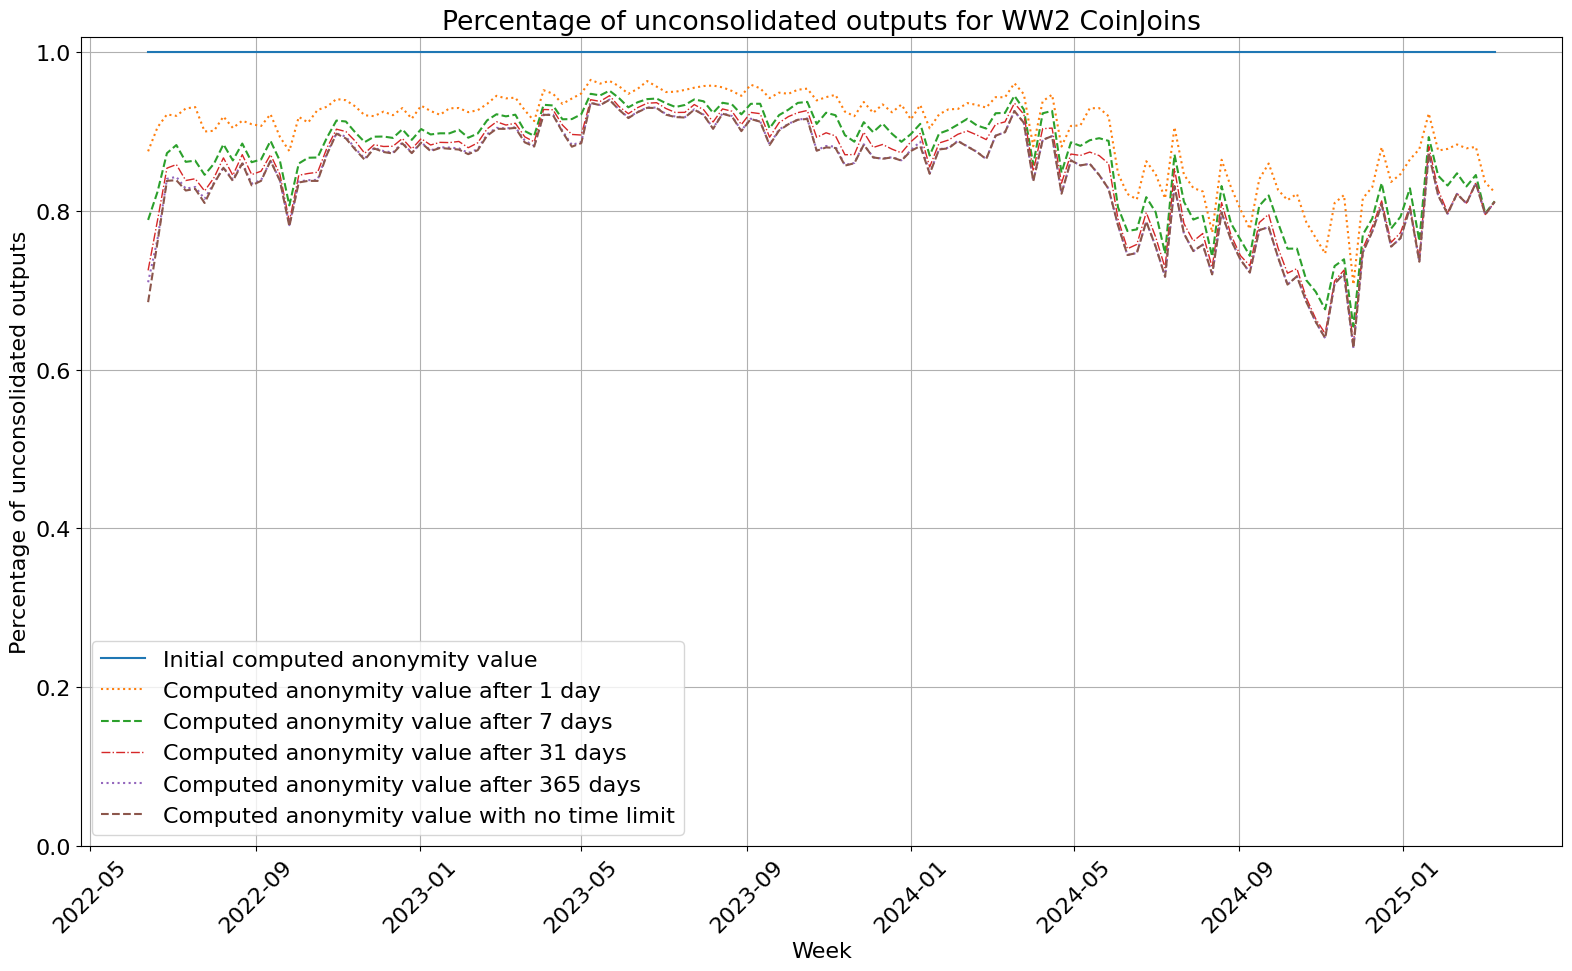

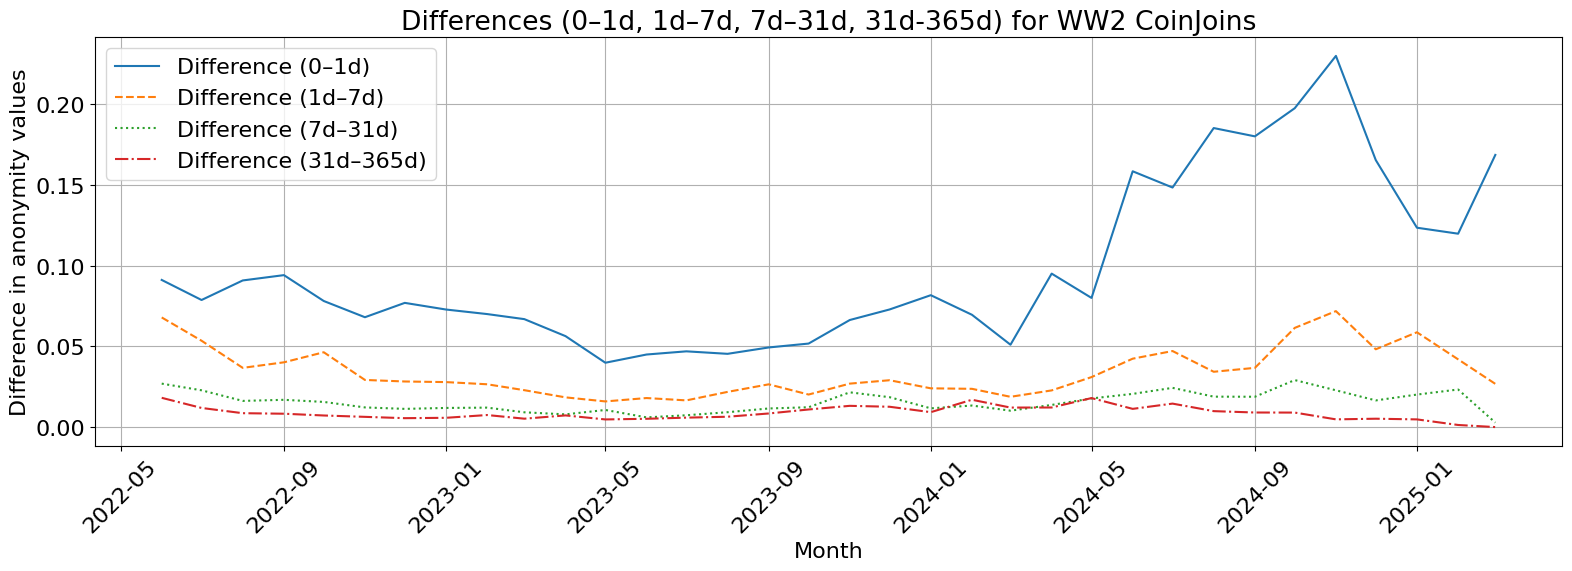

original mean 1.0
after day 0.9025602359276025
after week 0.8683037079762148
after month 0.8527790613861463
after year 0.8439023059997789


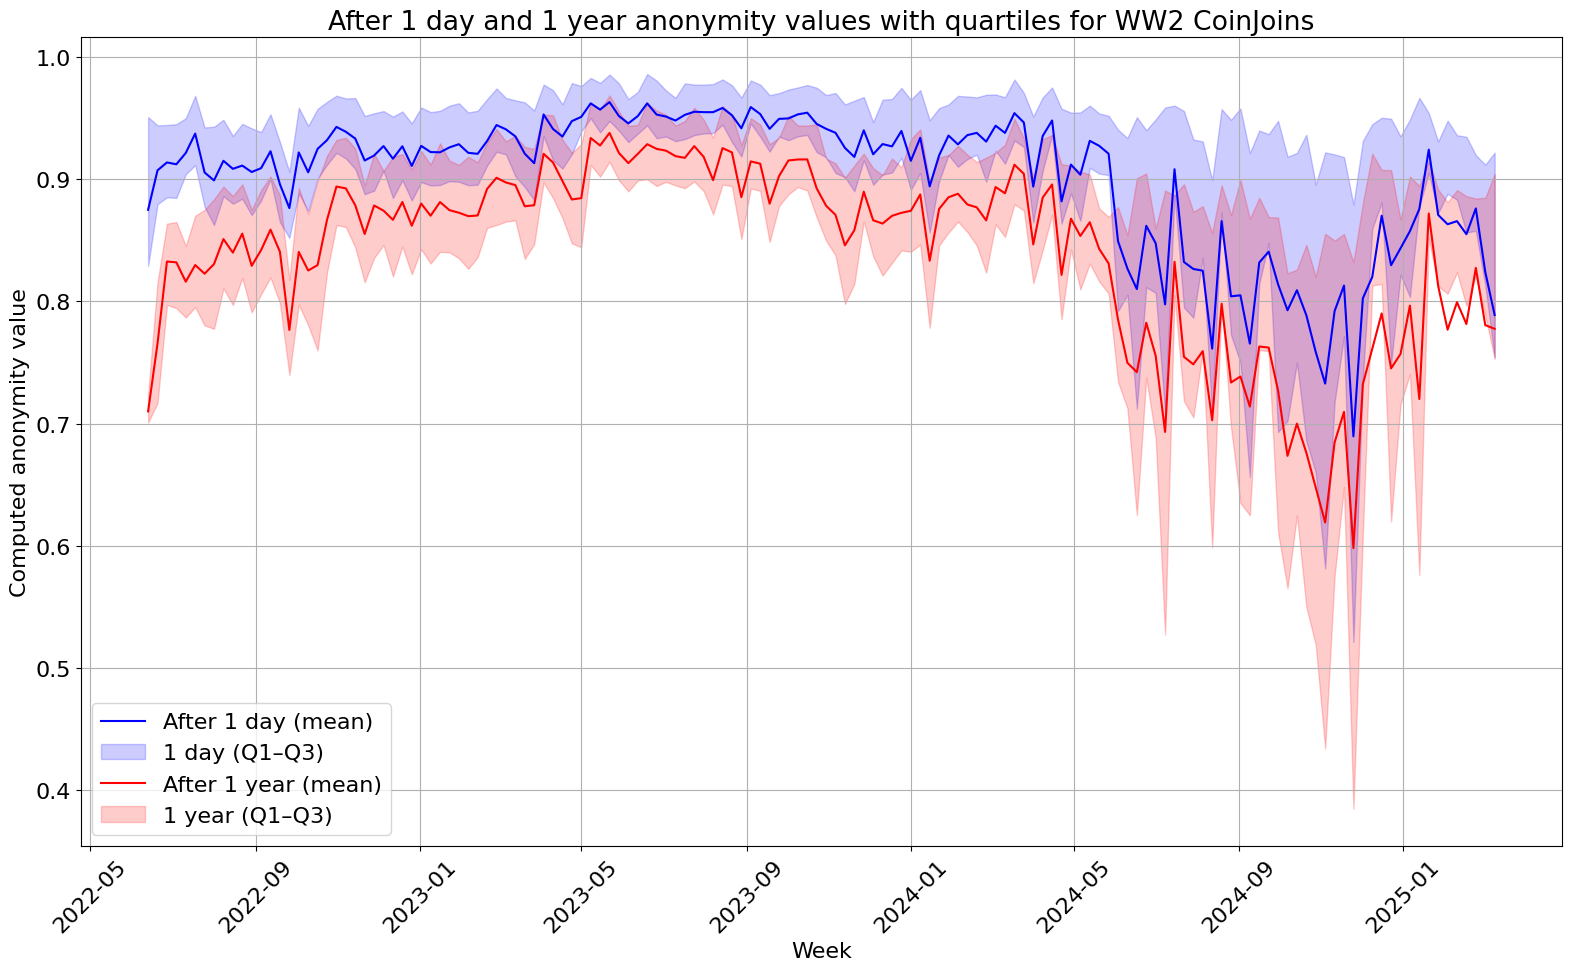

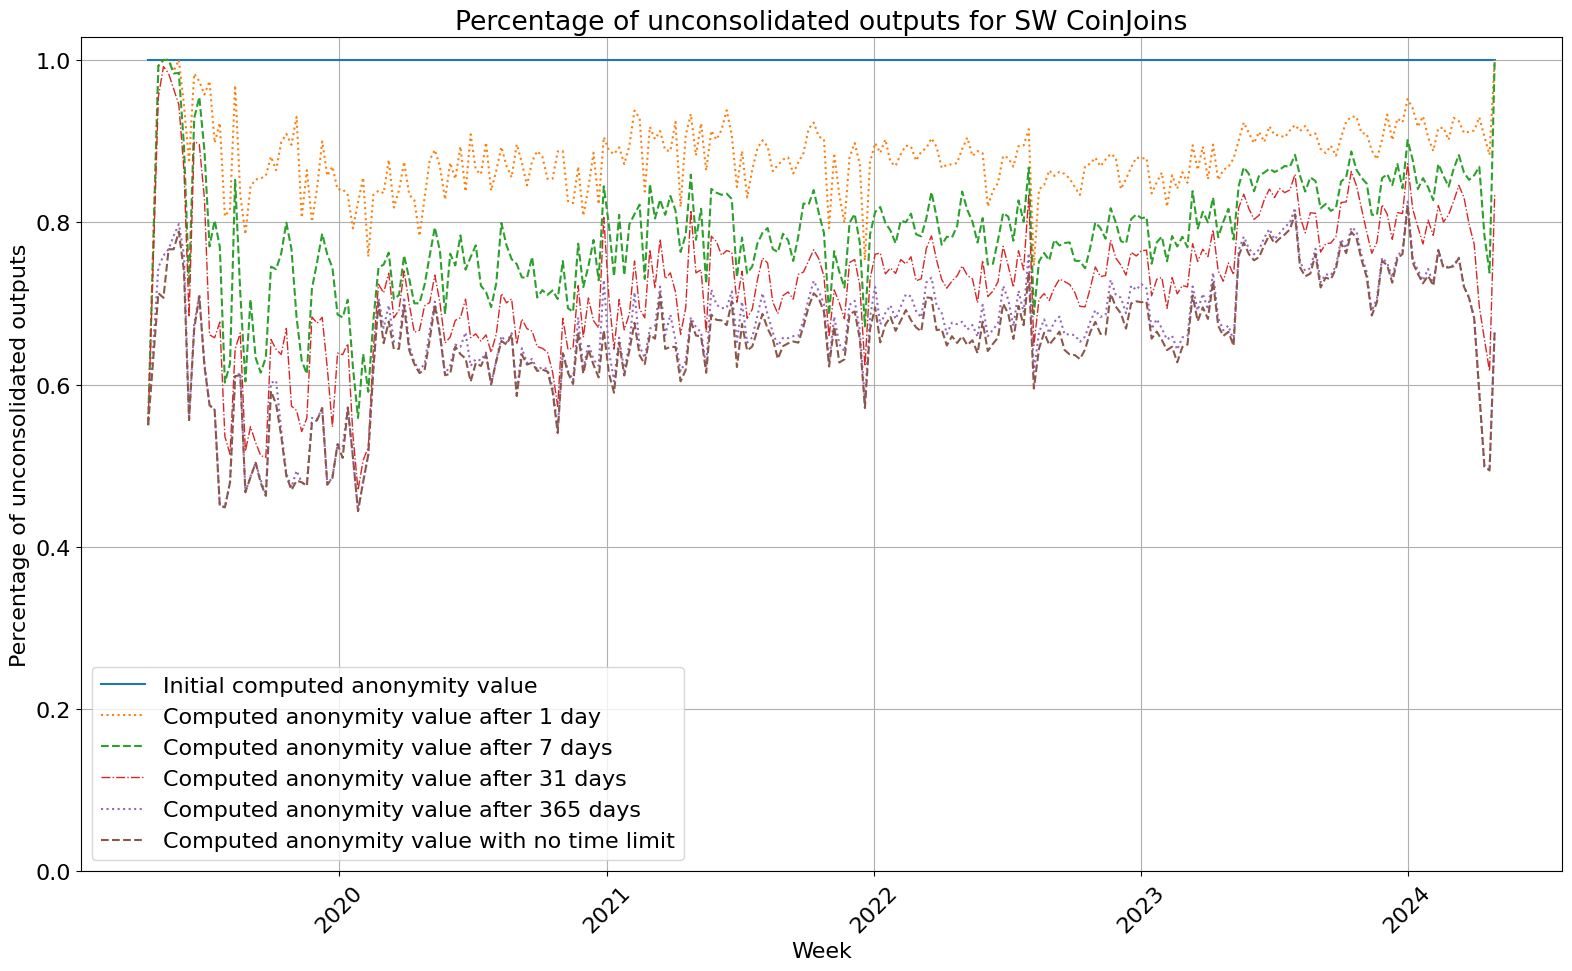

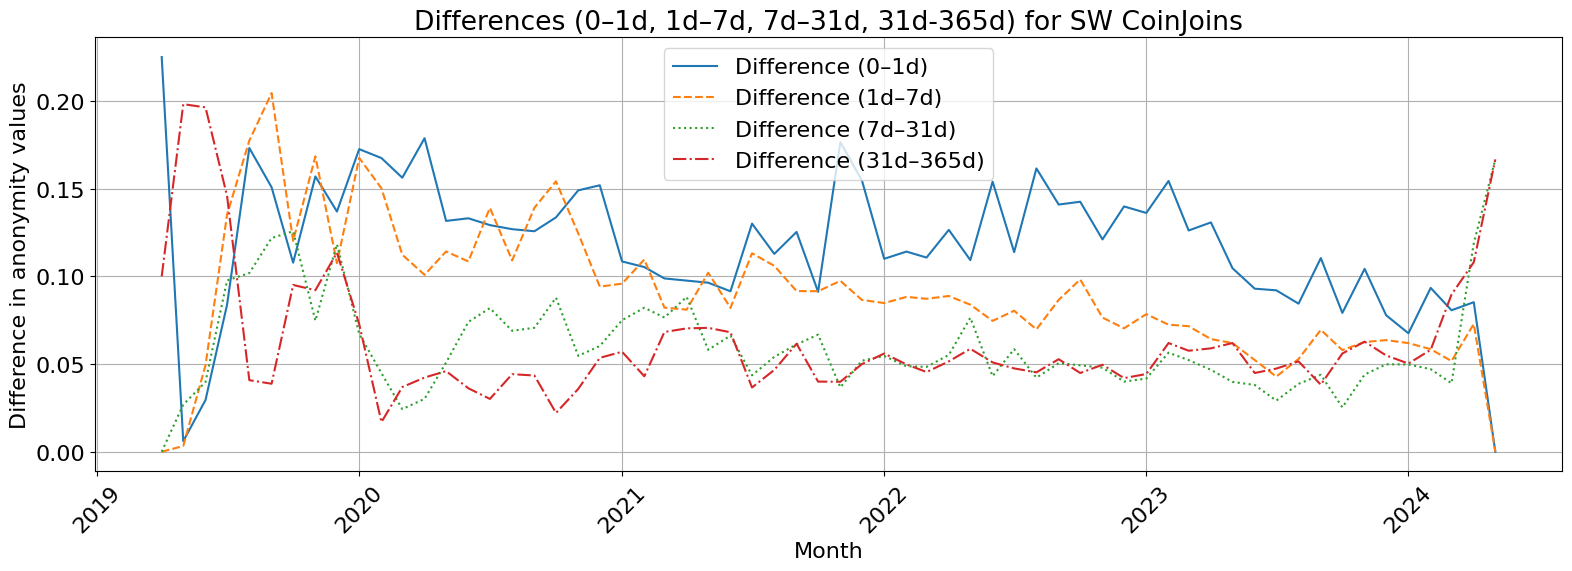

original mean 1.0
after day 0.8809996407899621
after week 0.7906461076436822
after month 0.7305802707015805
after year 0.6683275855470633


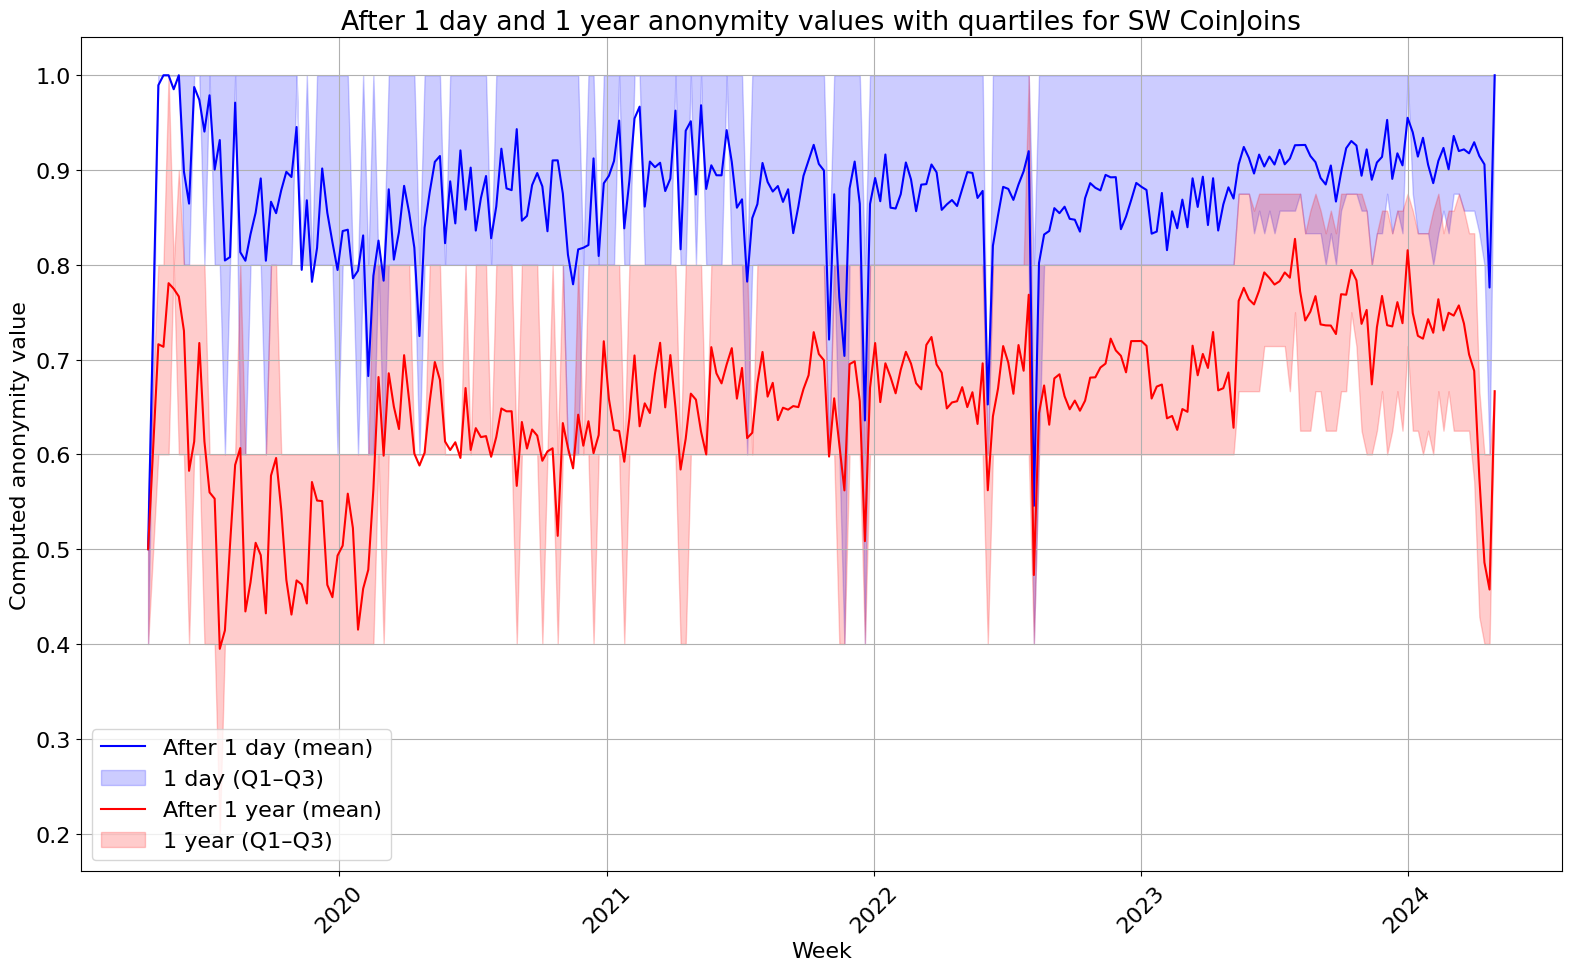

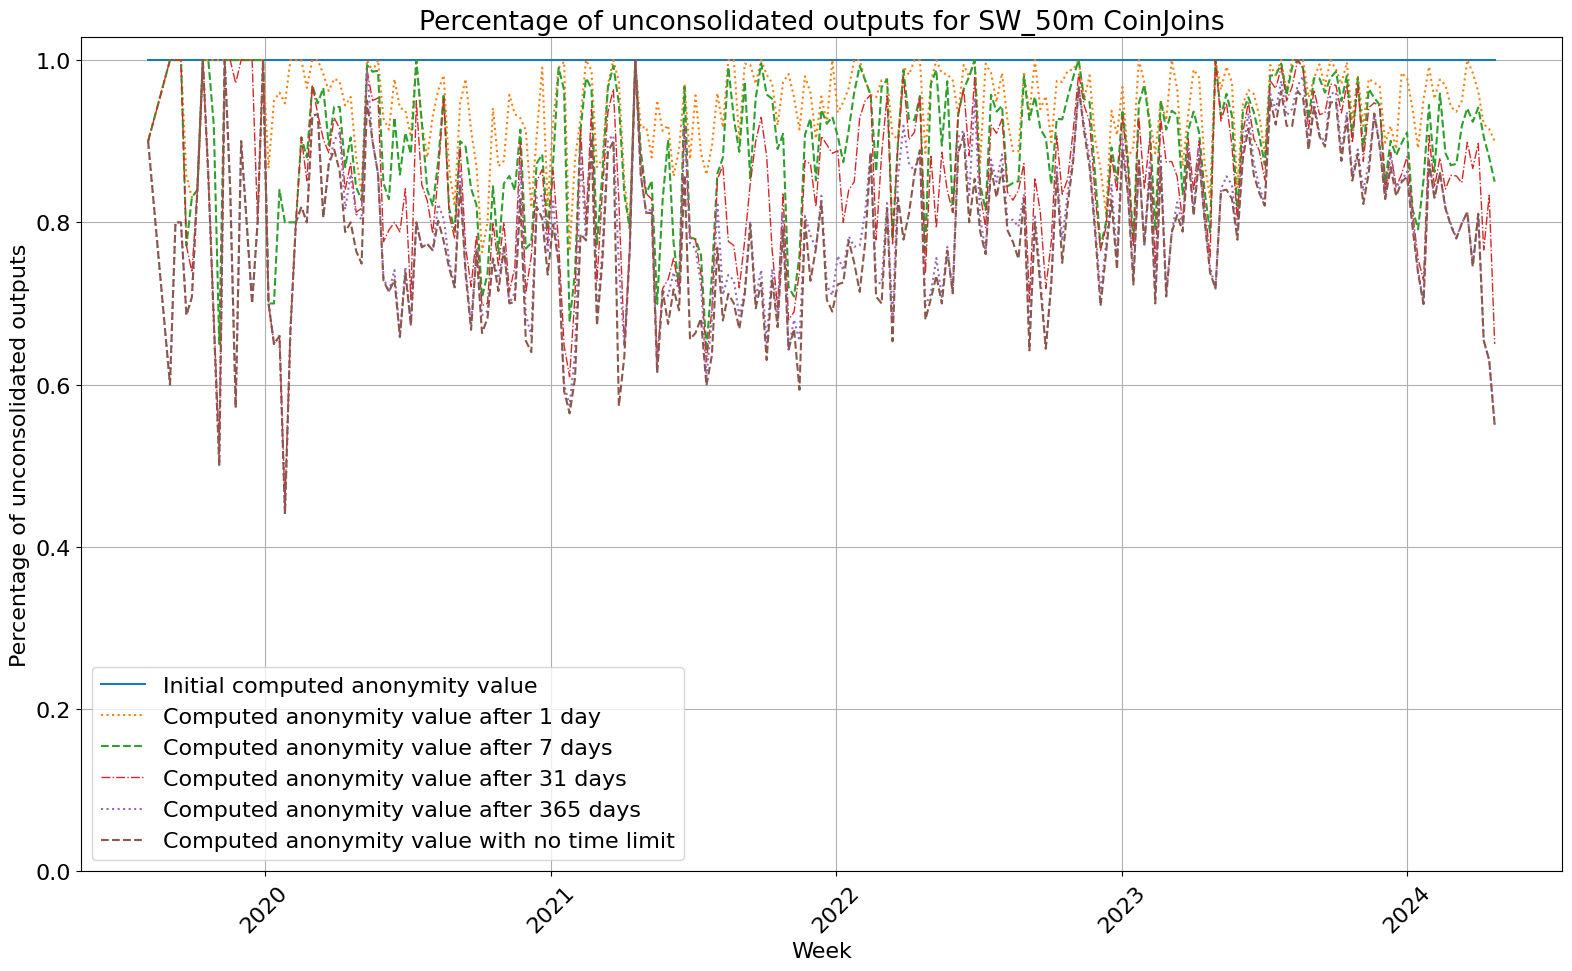

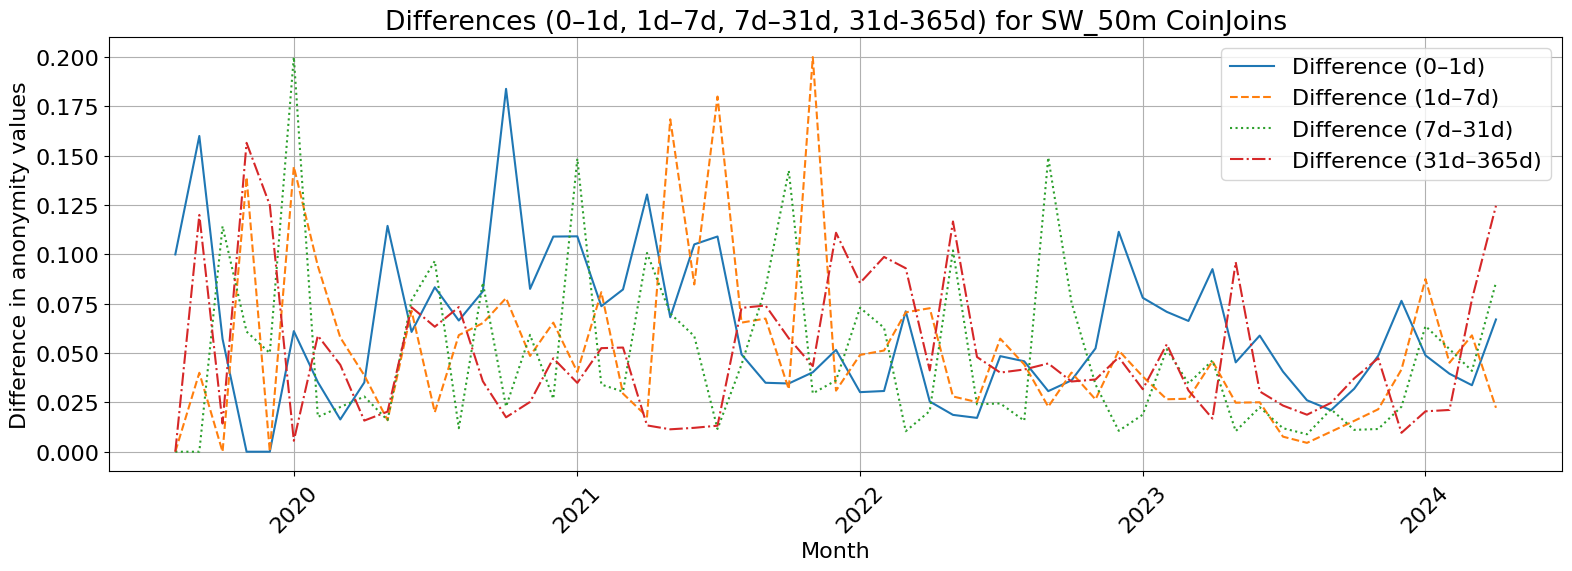

original mean 1.0
after day 0.9386100651820333
after week 0.8863929574101365
after month 0.8373435475548121
after year 0.7875230949788052


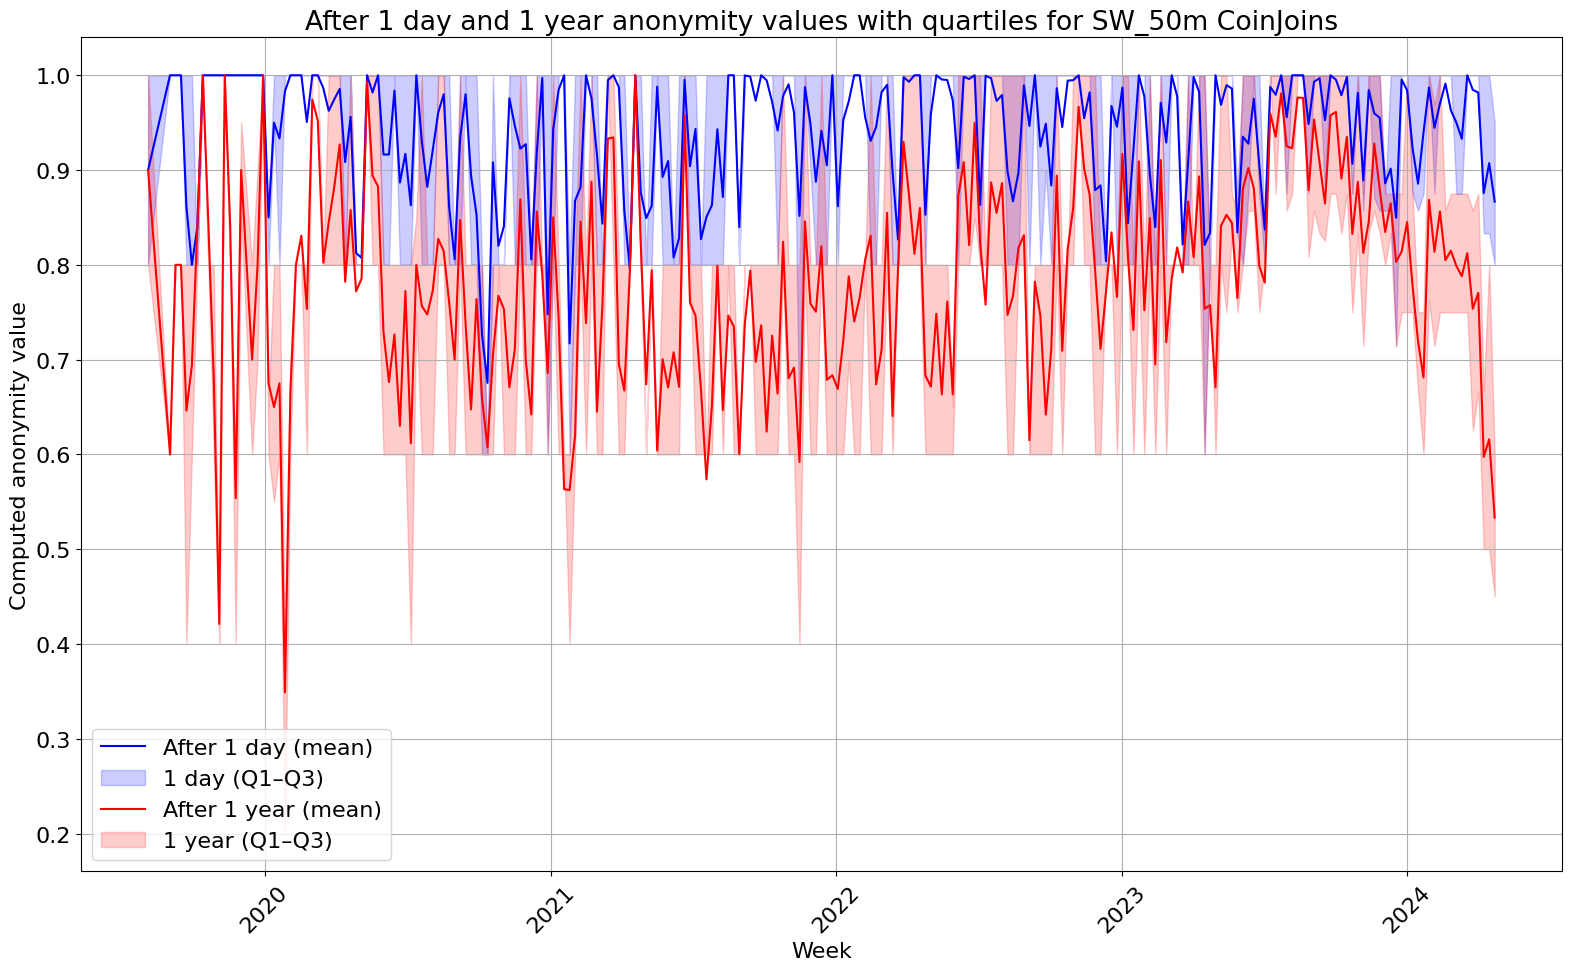

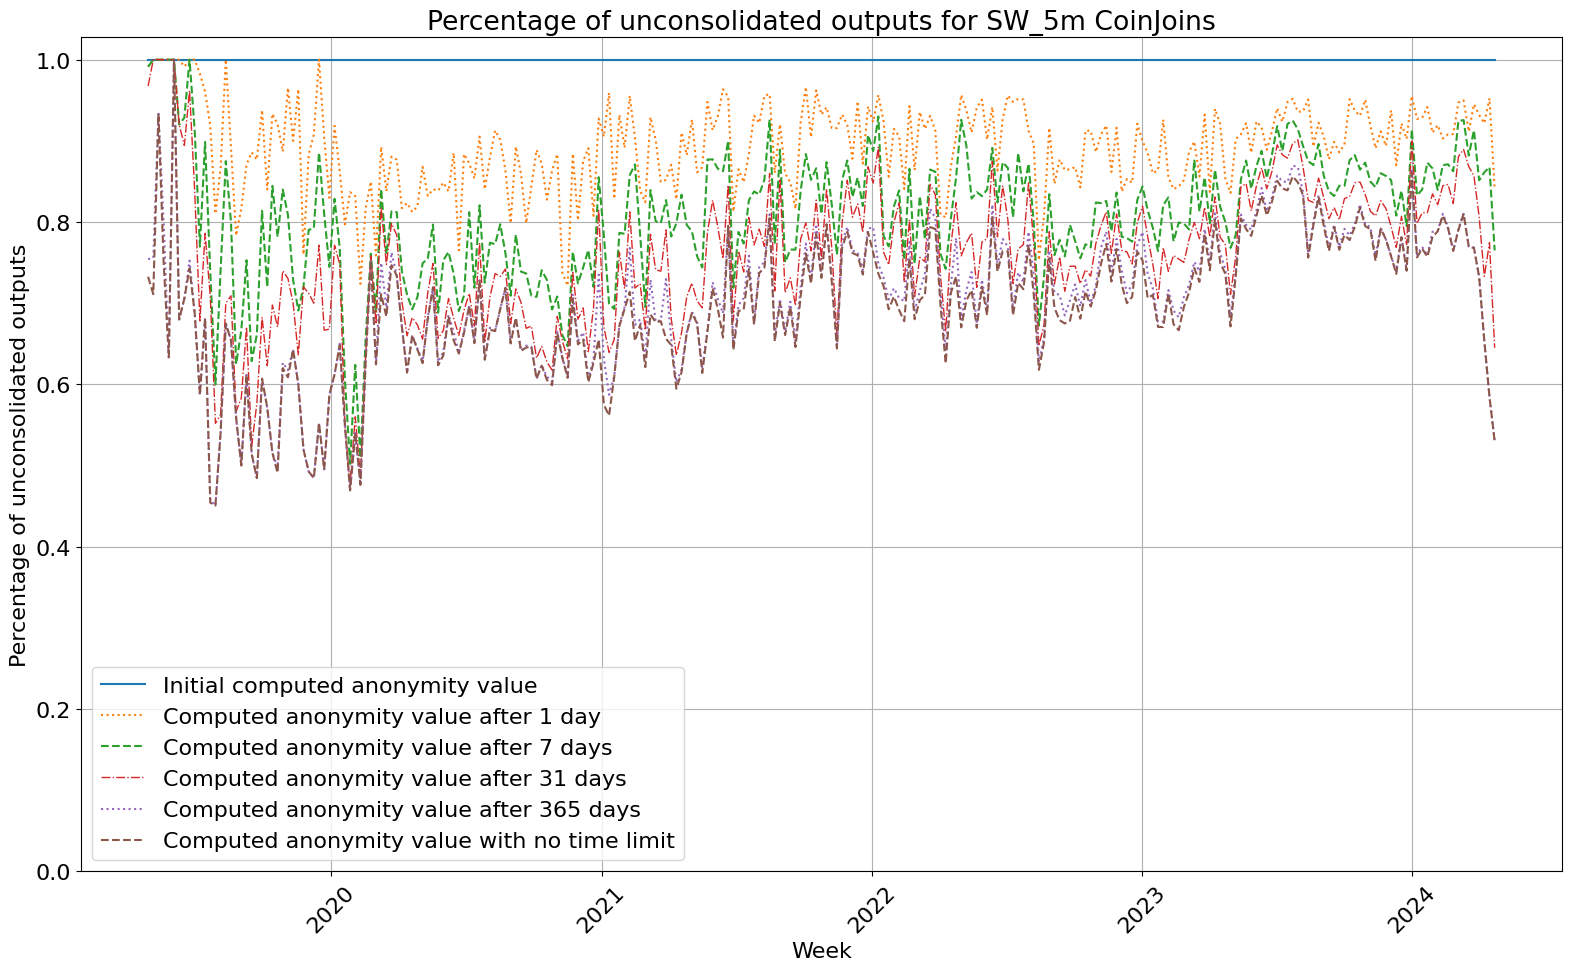

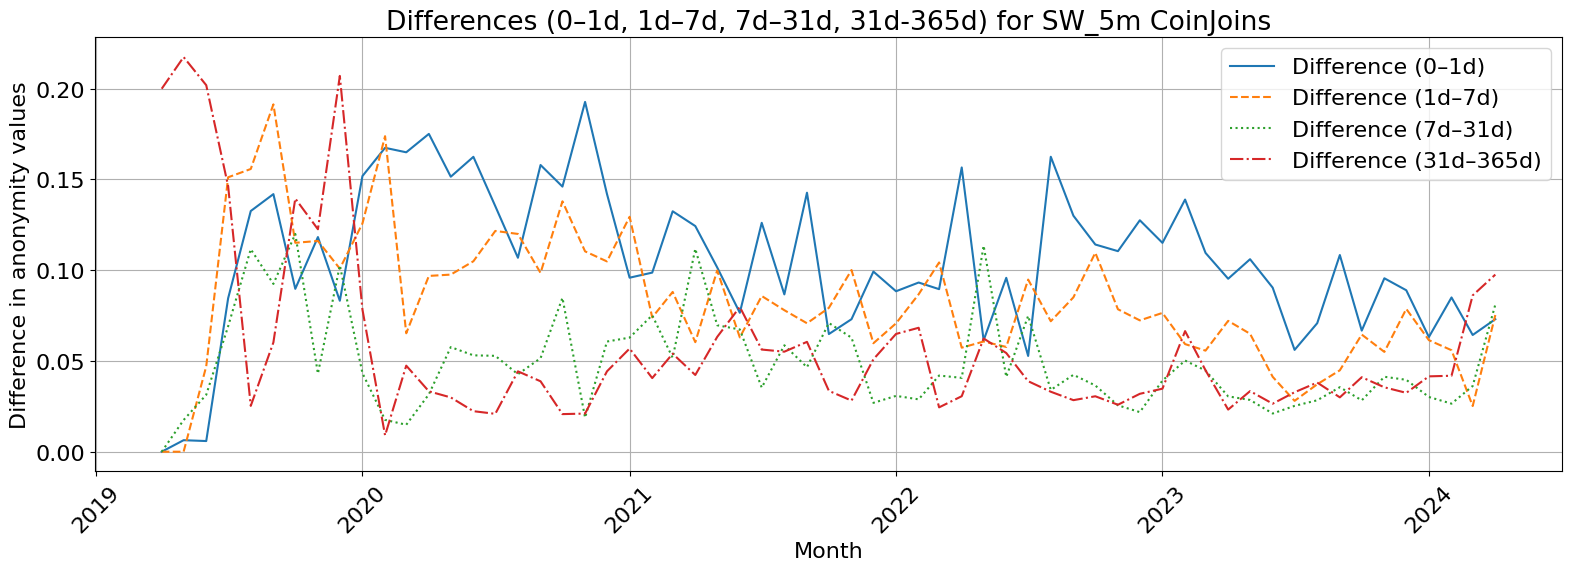

original mean 1.0
after day 0.8942731420316721
after week 0.8111632903248246
after month 0.7623796863501247
after year 0.7041535789756771


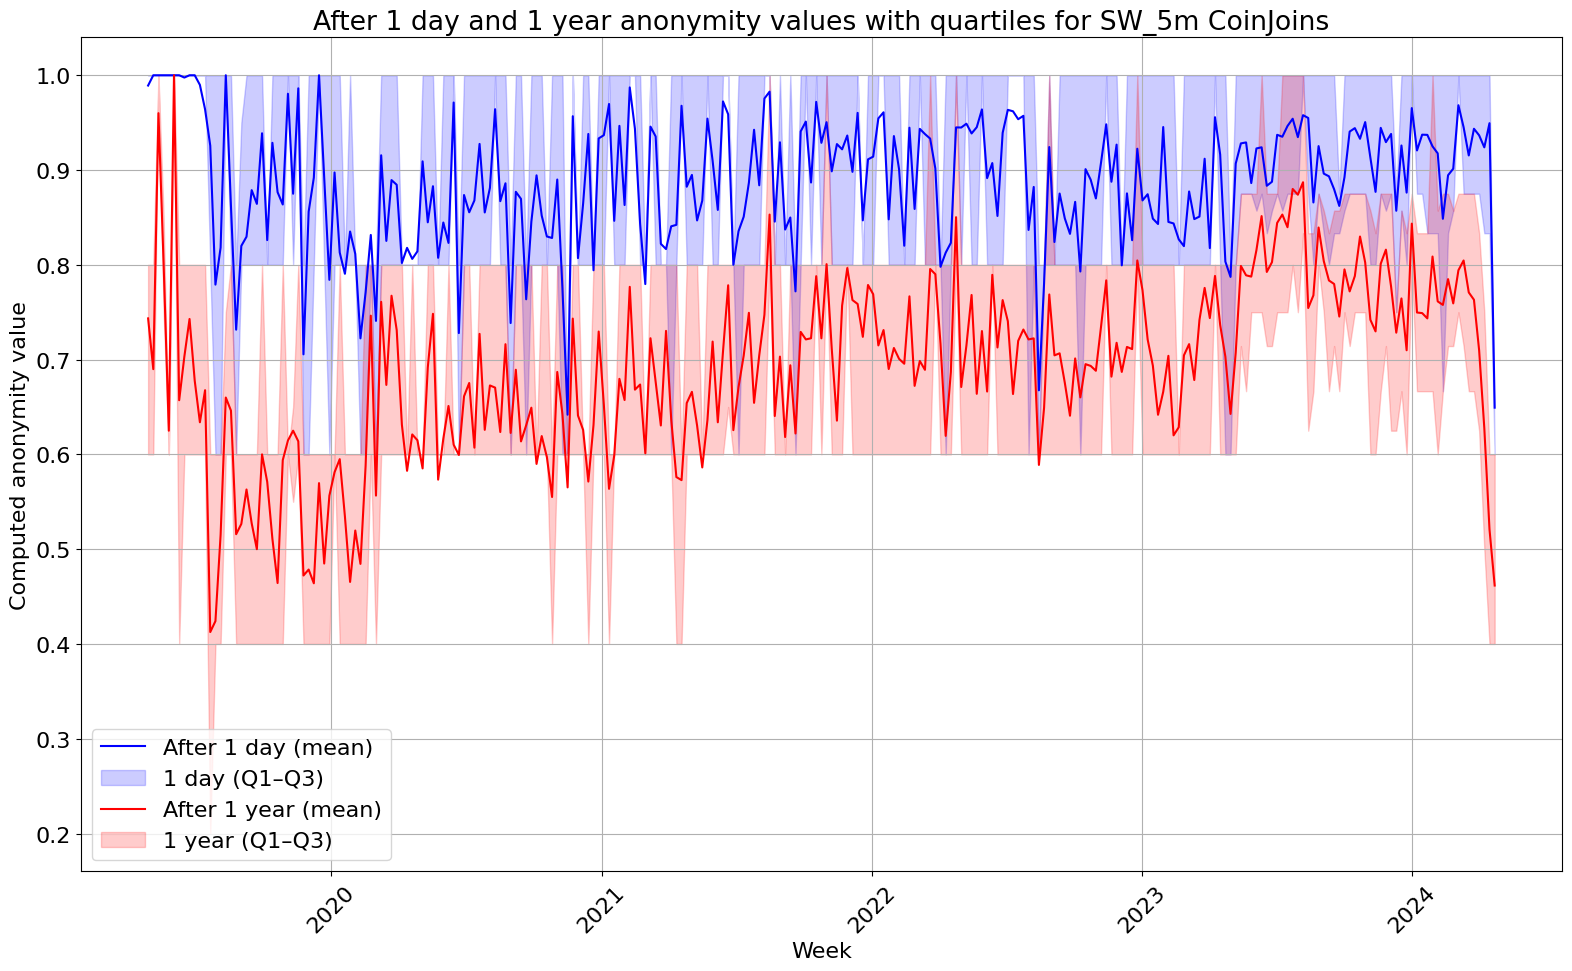

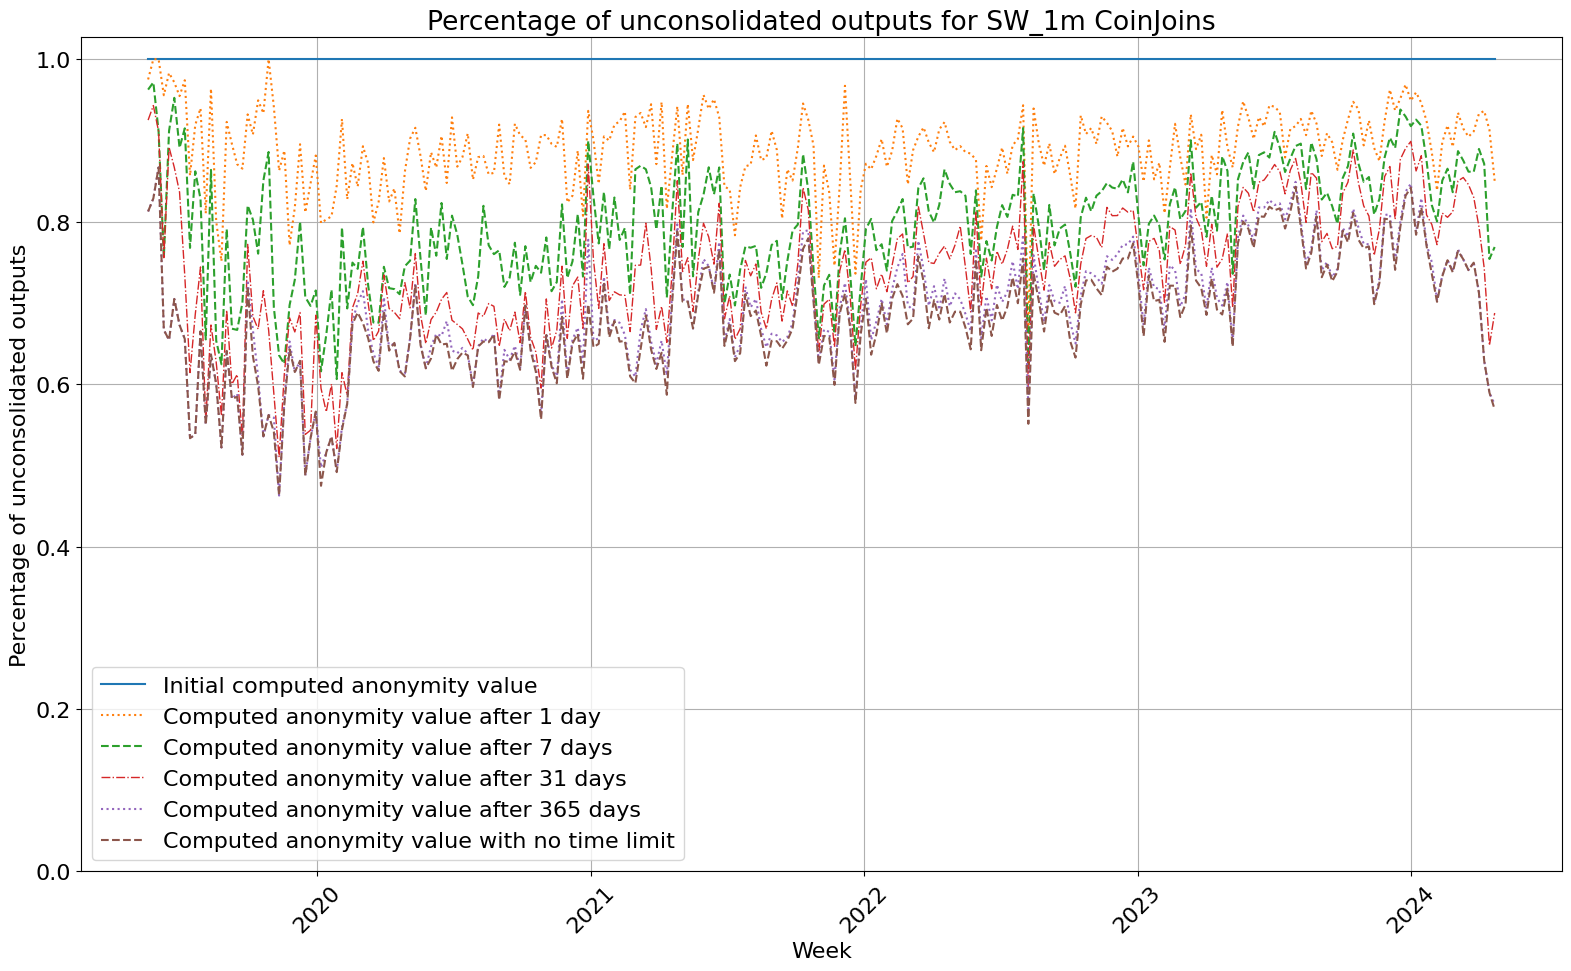

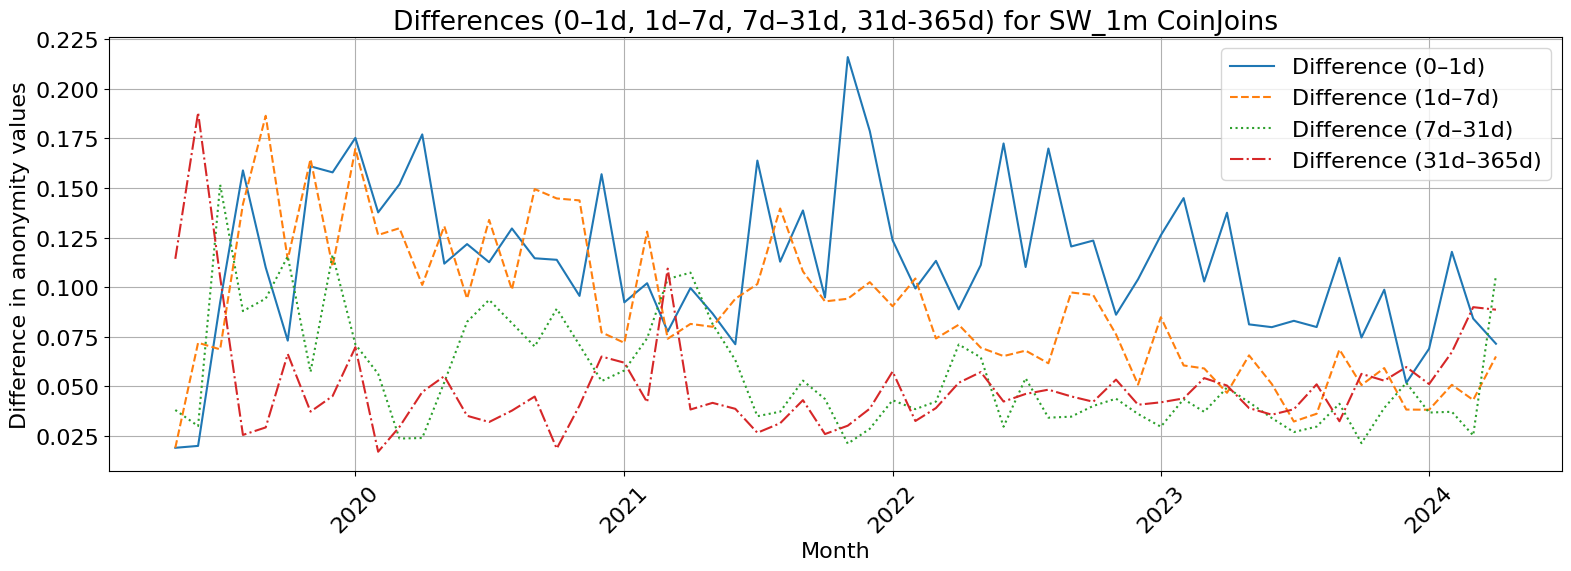

original mean 1.0
after day 0.8872389403740185
after week 0.7984022635859154
after month 0.7425689382563802
after year 0.6918825298678815


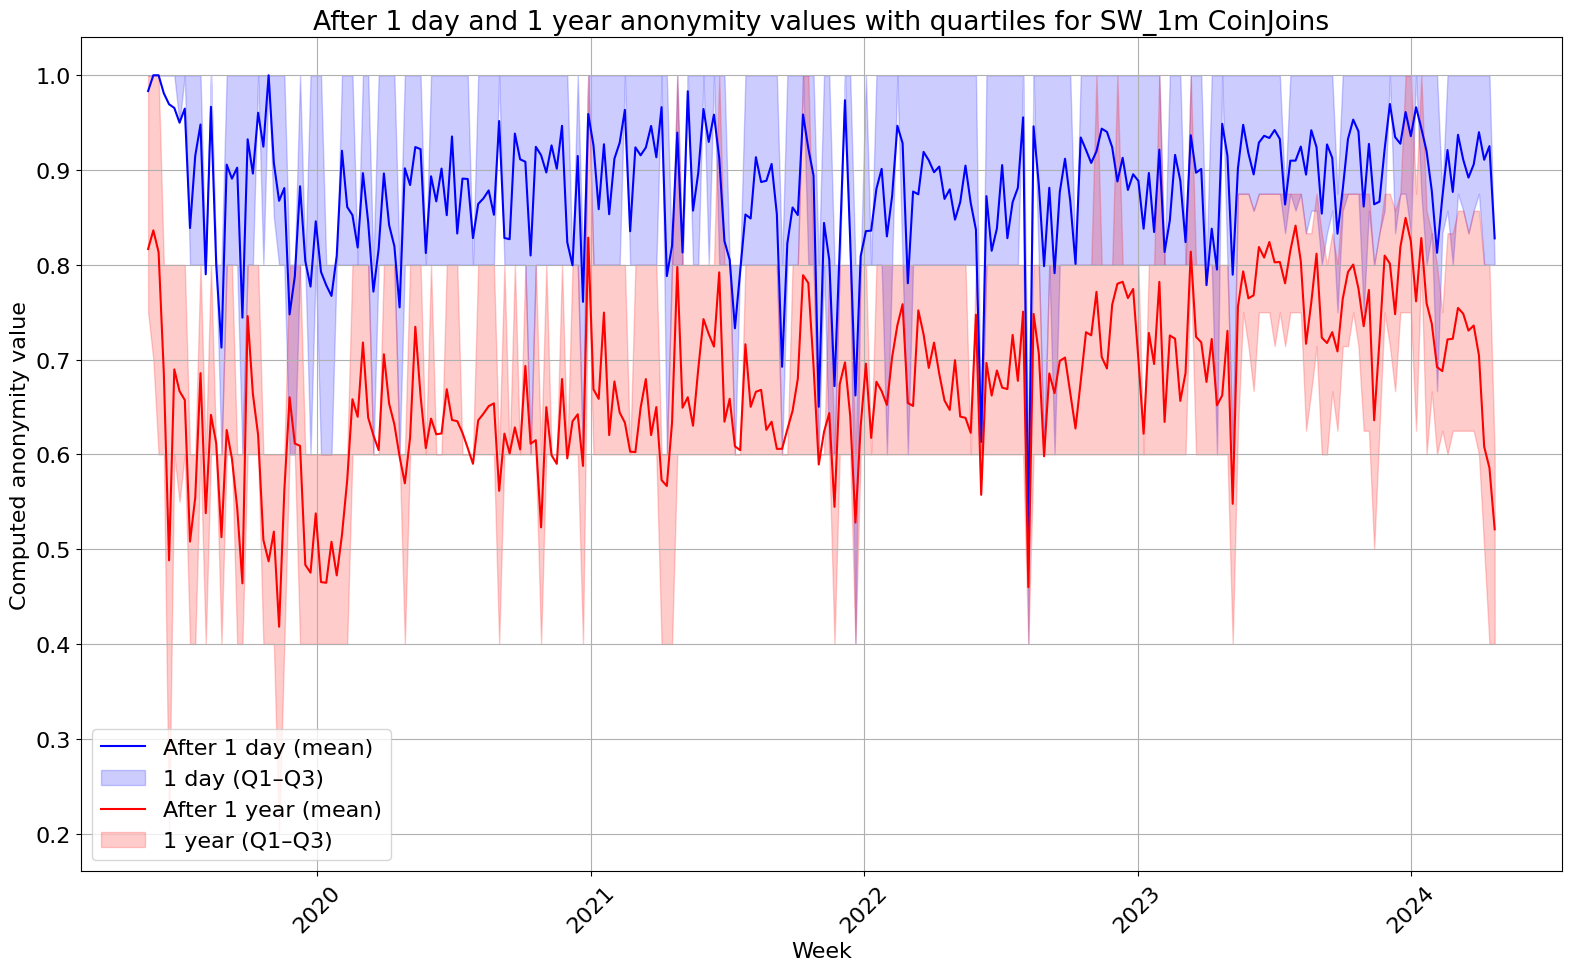

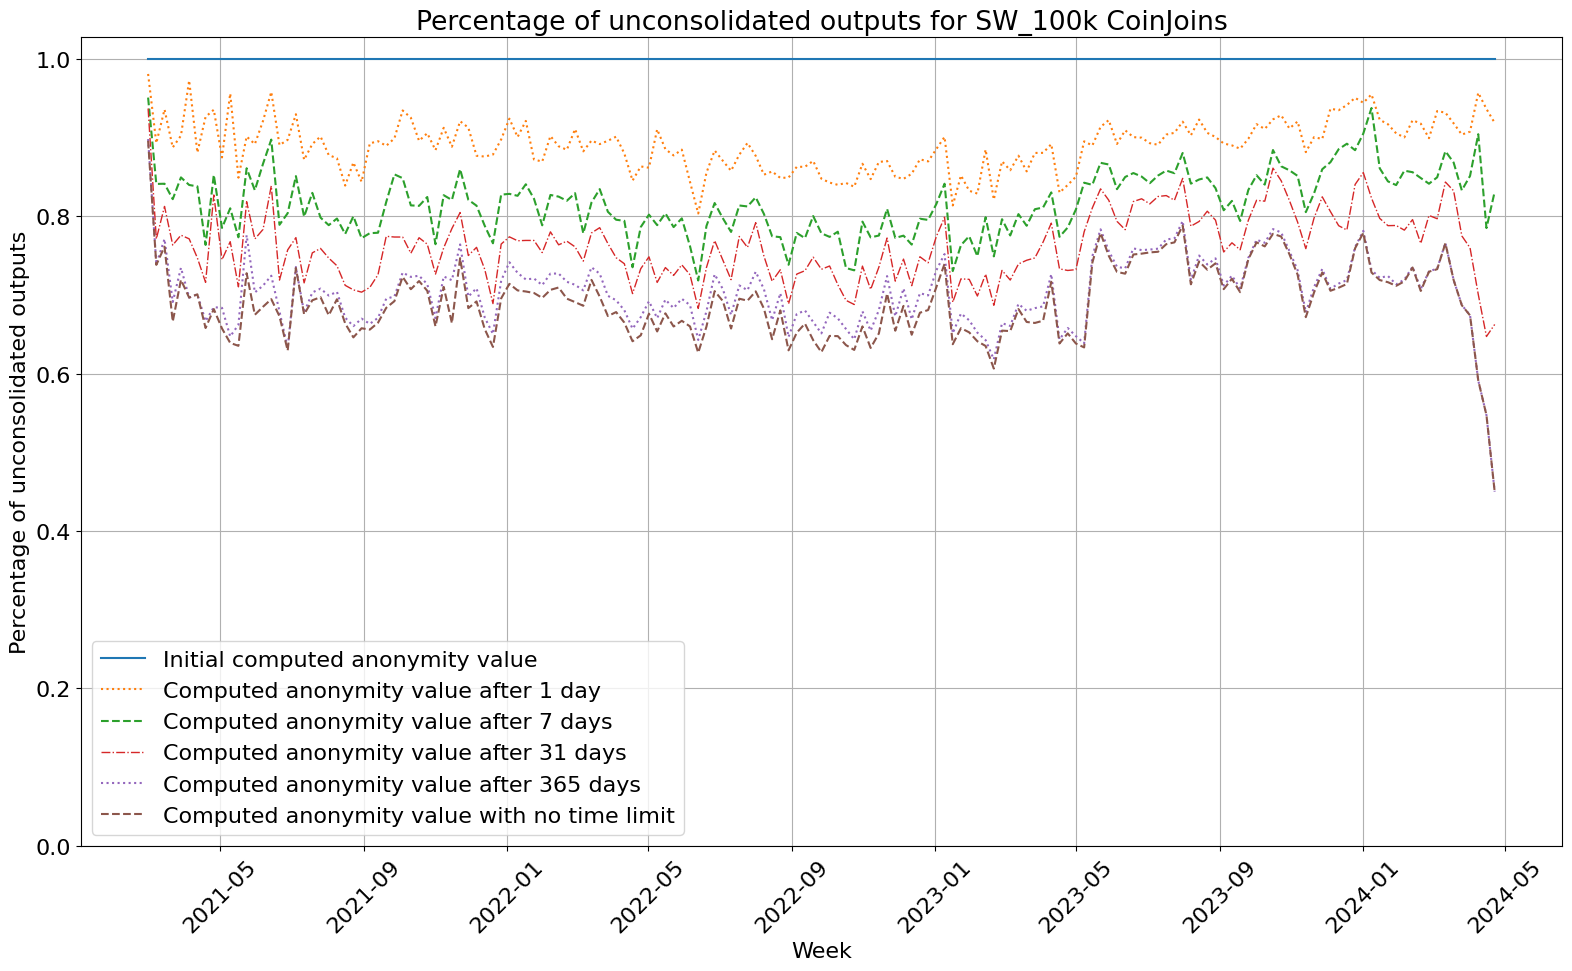

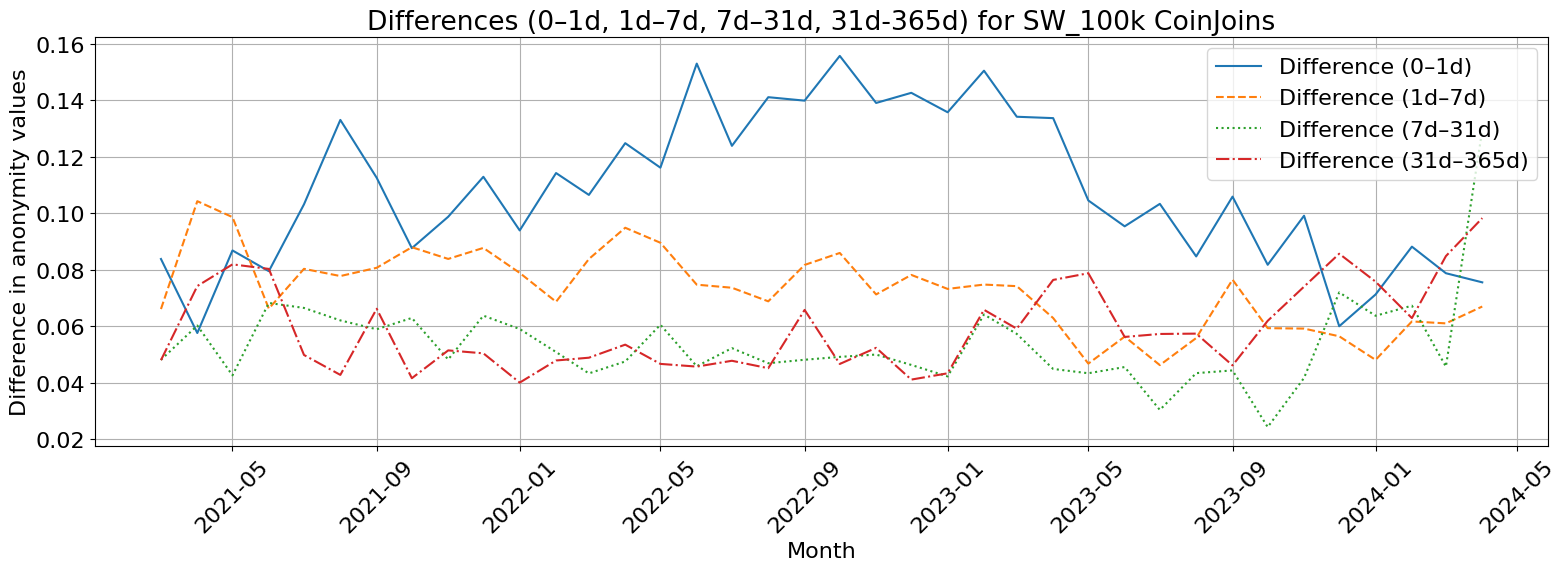

original mean 1.0
after day 0.89189078707746
after week 0.8191887480996274
after month 0.7654737365653982
after year 0.7062132977329415


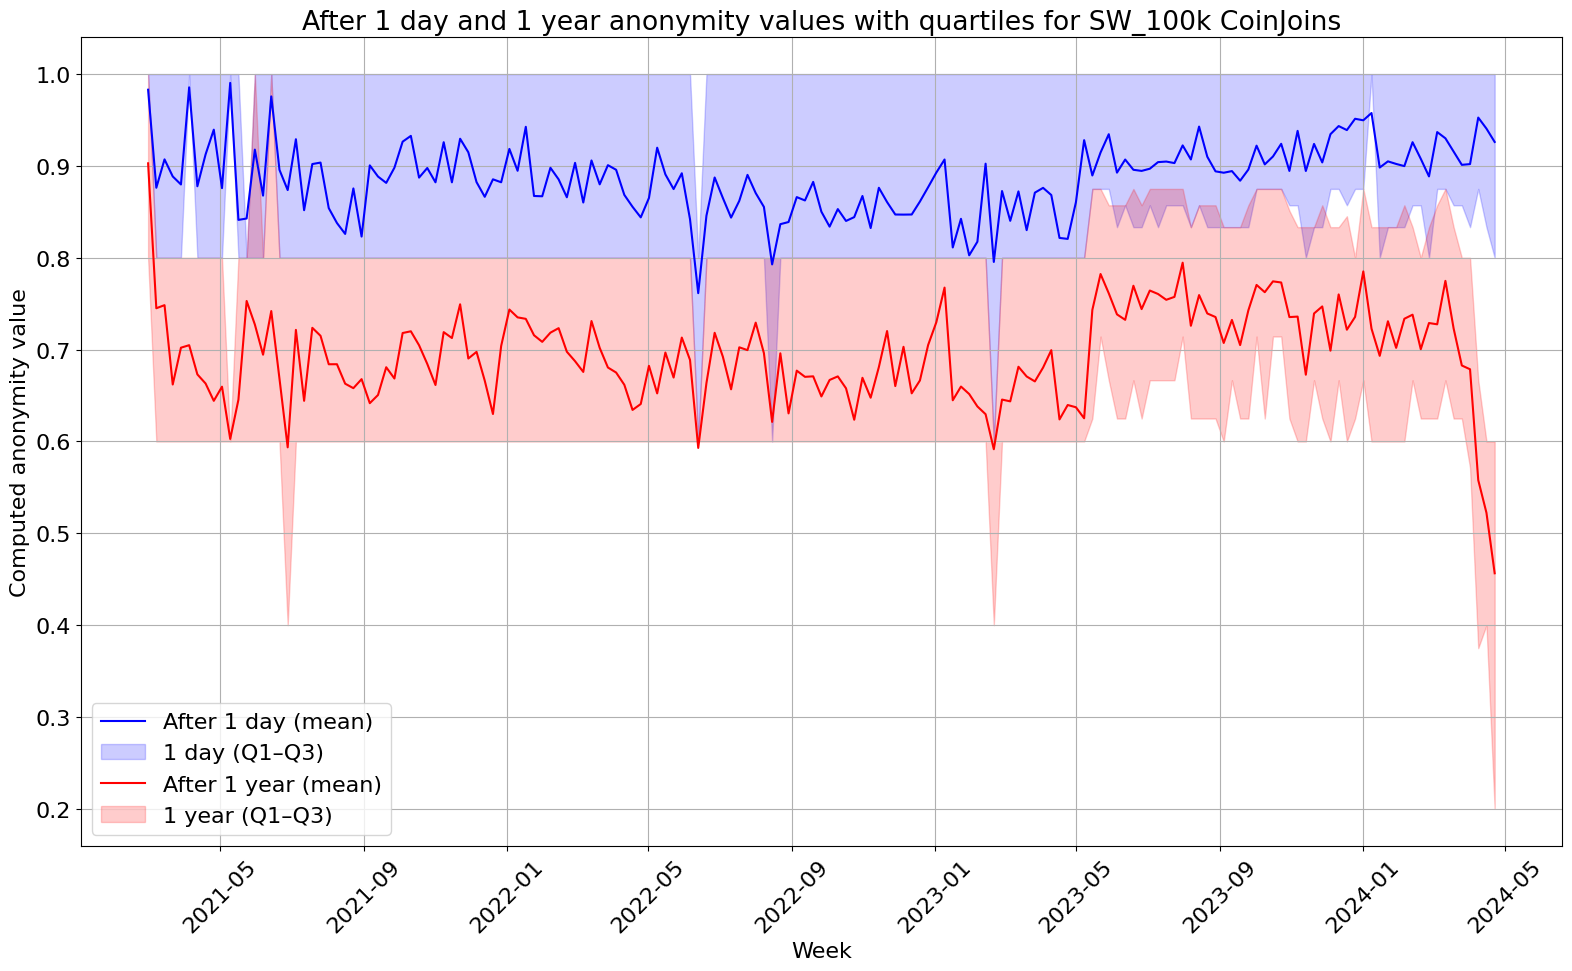

In [11]:
plot_anonymity_degradation(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, ww1_after_full_data, "ww1_multiple_txes")
compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")

plot_anonymity_degradation(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, ww2_after_full_data, "ww2_multiple_txes")
compute_and_plot_differences(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, "ww2_multiple_txes")
compute_and_plot_quartiles(ww2_after_day_data, ww2_after_year_data, "ww2_cjs")

plot_anonymity_degradation(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, sw_after_full_data, "sw_multiple_txes")
compute_and_plot_differences(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, "sw_multiple_txes")
compute_and_plot_quartiles(sw_after_day_data, sw_after_year_data, "sw_cjs")

plot_anonymity_degradation(sw_original_data_50m, sw_after_day_data_50m, sw_after_week_data_50m, sw_after_month_data_50m, sw_after_year_data_50m, sw_after_full_data_50m, "sw_multiple_txes", "50m")
compute_and_plot_differences(sw_original_data_50m, sw_after_day_data_50m, sw_after_week_data_50m, sw_after_month_data_50m, sw_after_year_data_50m, "sw_multiple_txes", "50m")
compute_and_plot_quartiles(sw_after_day_data_50m, sw_after_year_data_50m, "sw_cjs", "50m")

plot_anonymity_degradation(sw_original_data_5m, sw_after_day_data_5m, sw_after_week_data_5m, sw_after_month_data_5m, sw_after_year_data_5m, sw_after_full_data_5m, "sw_multiple_txes", "5m")
compute_and_plot_differences(sw_original_data_5m, sw_after_day_data_5m, sw_after_week_data_5m, sw_after_month_data_5m, sw_after_year_data_5m, "sw_multiple_txes", "5m")
compute_and_plot_quartiles(sw_after_day_data_5m, sw_after_year_data_5m, "sw_cjs", "5m")


plot_anonymity_degradation(sw_original_data_1m, sw_after_day_data_1m, sw_after_week_data_1m, sw_after_month_data_1m, sw_after_year_data_1m, sw_after_full_data_1m, "sw_multiple_txes", "1m")
compute_and_plot_differences(sw_original_data_1m, sw_after_day_data_1m, sw_after_week_data_1m, sw_after_month_data_1m, sw_after_year_data_1m, "sw_multiple_txes", "1m")
compute_and_plot_quartiles(sw_after_day_data_1m, sw_after_year_data_1m, "sw_cjs", "1m")


plot_anonymity_degradation(sw_original_data_100k, sw_after_day_data_100k, sw_after_week_data_100k, sw_after_month_data_100k, sw_after_year_data_100k, sw_after_full_data_100k, "sw_multiple_txes", "100k")
compute_and_plot_differences(sw_original_data_100k, sw_after_day_data_100k, sw_after_week_data_100k, sw_after_month_data_100k, sw_after_year_data_100k, "sw_multiple_txes", "100k")
compute_and_plot_quartiles(sw_after_day_data_100k, sw_after_year_data_100k, "sw_cjs", "100k")

In [8]:
%time ww1_ign_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1", ignoreNonStandardDenominations=True)
%time ww1_ign_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1", ignoreNonStandardDenominations=True)

CPU times: user 2min 48s, sys: 411 ms, total: 2min 49s
Wall time: 2.47 s
CPU times: user 27min 32s, sys: 453 ms, total: 27min 32s
Wall time: 11.3 s
CPU times: user 28min 24s, sys: 2.53 s, total: 28min 27s
Wall time: 11.9 s
CPU times: user 28min 25s, sys: 2.35 s, total: 28min 27s
Wall time: 12.6 s
CPU times: user 28min 37s, sys: 638 ms, total: 28min 37s
Wall time: 12.4 s
CPU times: user 28min 29s, sys: 929 ms, total: 28min 30s
Wall time: 12.6 s


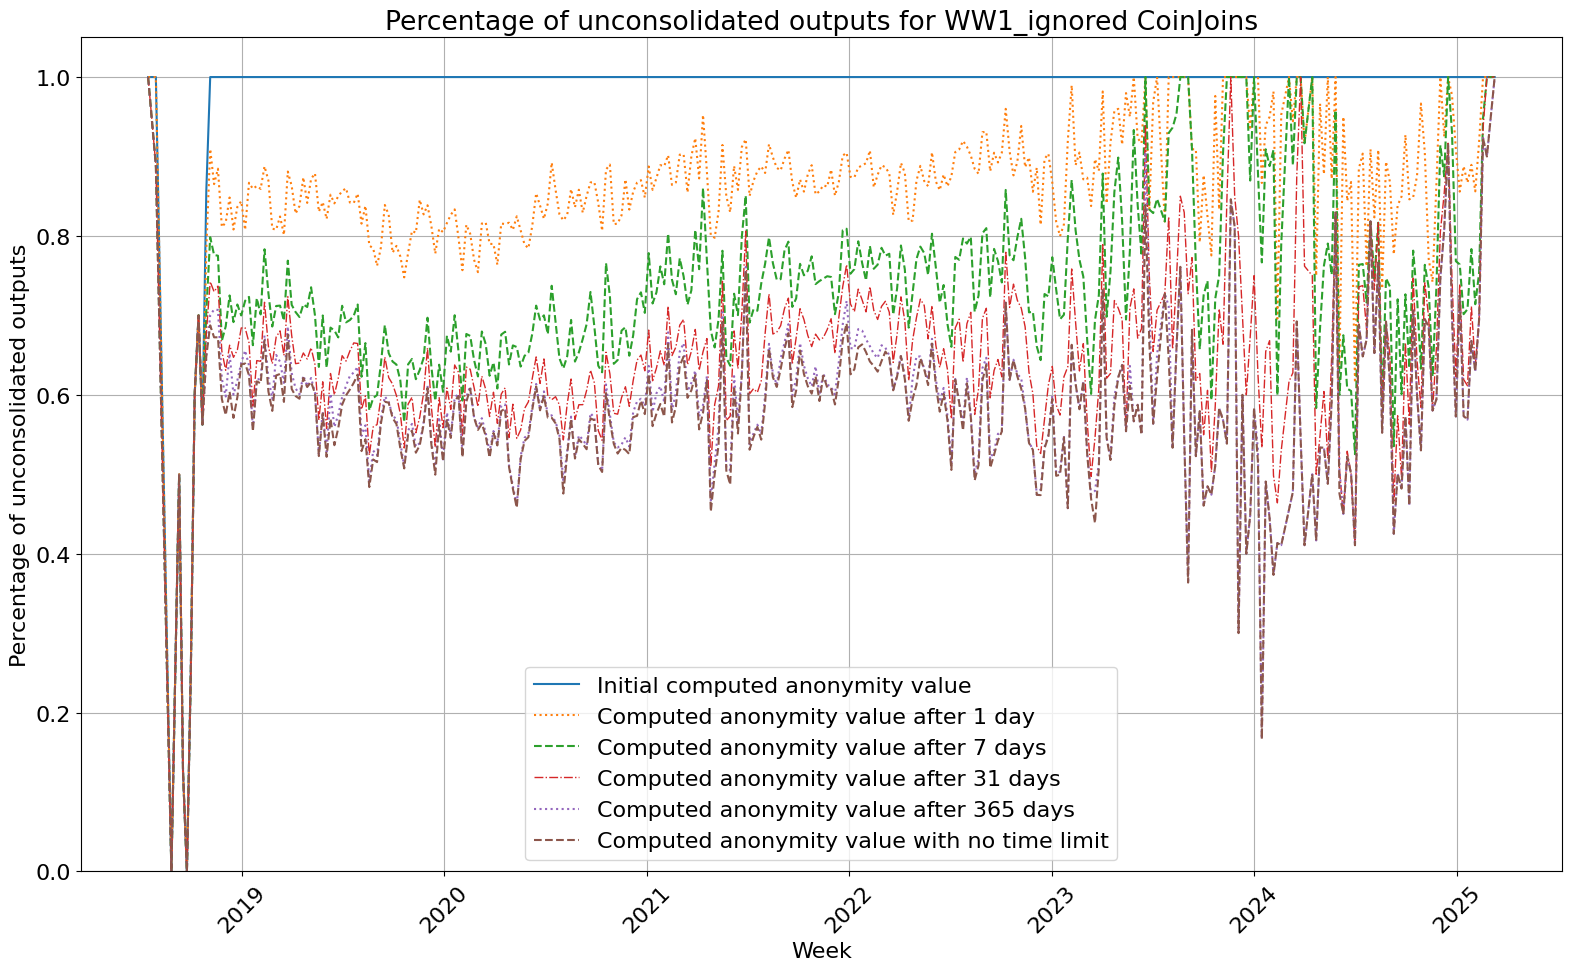

In [14]:
plot_anonymity_degradation(ww1_ign_original_data, ww1_ign_after_day_data, ww1_ign_after_week_data, ww1_ign_after_month_data, ww1_ign_after_year_data, ww1_ign_after_full_data, "ww1_multiple_txes", "ignored")
# compute_and_plot_quartiles(ww1_after_day_data, ww1_after_year_data, "ww1_cjs")
# compute_and_plot_differences(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, "ww1_multiple_txes")
